<a href="https://colab.research.google.com/github/Kennedy87670/Introduction-to-ML-DP/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tranfer Learning with Tensorflow part 3: scaling up Food vision mini

We have seen the power of transfer learning fature extraction and fine-tuning, now its time to scale up to all of the classes in Food101 (101 total classes of food)

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning)

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76 accuracy accross 101 classes

In [2]:
# check to see if we are using a GPu
!nvidia-smi

Fri Jul 29 19:20:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## creating helper functions

In previous notebooks we have created a series of helper functions to do different tasks. lets download them

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-29 19:20:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-29 19:20:07 (118 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

##  101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so lets download it.

The data we are downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb 

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-07-29 19:20:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 142.250.188.48, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   110MB/s    in 12s     

2022-07-29 19:20:22 (130 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# how many image/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_onion_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 25

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode= "categorical",
                                                                               image_size= IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode= "categorical",
                                                              image_size= IMG_SIZE,
                                                               shuffle=False) # dont shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


from tensorflow.python.ops.gen_math_ops import cast_eager_fallback
# Traina big dog model with transfer learning on 10% of 101 food classes

Here arethe steps we are going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model(we will create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the trai dataset and validation on 15% of the test data, to save epoch time)

In [8]:
# Create a checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [9]:
# Createdata augmenatation layer to incorporate it right into the model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [10]:
# setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# # setup model architecture with trainable top layers
# inputs = layers.Input(shape=(224,224,3), name="input_layer")
# x = data_augmentation(inputs) # augment images (only happens during training phase)
# x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen stay frozen
# x = layers.GlobalAveragePooling2D(name= "global_average_pool_layer")(x)
# ouputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name= "output_layer")(x)
# model = tf.keras.Model(inputs, outputs)

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
# get a summary of model we have created 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
# compile 
model.compile(loss= "categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 90s 308ms/step - loss: 3.4694 - accuracy: 0.2474 - val_loss: 2.6689 - val_accuracy: 0.3919
Epoch 2/5
237/237 [==============================] - 59s 246ms/step - loss: 2.3486 - accuracy: 0.4614 - val_loss: 2.2034 - val_accuracy: 0.4711
Epoch 3/5
237/237 [==============================] - 50s 209ms/step - loss: 1.9822 - accuracy: 0.5263 - val_loss: 2.0606 - val_accuracy: 0.4894
Epoch 4/5
237/237 [==============================] - 48s 201ms/step - loss: 1.7751 - accuracy: 0.5728 - val_loss: 1.9856 - val_accuracy: 0.4974
Epoch 5/5
237/237 [==============================] - 48s 203ms/step - loss: 1.5970 - accuracy: 0.6094 - val_loss: 1.9482 - val_accuracy: 0.5019


In [13]:
# Evaluate on the whole test dataset
fine_extraction_results= model.evaluate(test_data)
fine_extraction_results

790/790 [==============================] - 56s 70ms/step - loss: 1.7204 - accuracy: 0.5524


[1.7203643321990967, 0.5523564219474792]

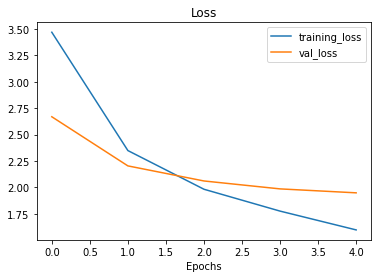

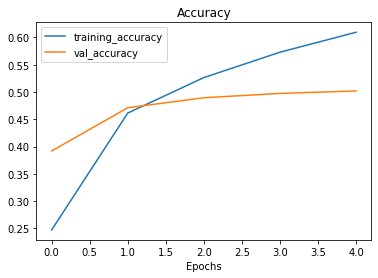

In [14]:
plot_loss_curves(history_all_classes_10_percent)

** Question** what do these curves suggst? Hint: ideally, the two curves should be very similar to each other if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data). 

## Fine-tuning 

In [15]:
# Unfreeze all of the layers in the base model
base_model.trainable =True

# Refreeze everylayer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable= False

In [16]:
# Recompile model with lower learning (its typically best pratice to lower the learning rate when )
# compile 
model.compile(loss= "categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(lr=0.0001),# learning rate lowered by 10x
              metrics=["accuracy"])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
# what layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [18]:
# check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable )

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [19]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has aleady done 5 epochs(feature extraction), this is the total number of epochs we are after


# fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                           epochs=fine_tune_epochs, 
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           initial_epoch = history_all_classes_10_percent.epoch[-1]
                                           ) 

Epoch 5/10
237/237 [==============================] - 52s 191ms/step - loss: 1.3528 - accuracy: 0.6515 - val_loss: 1.8879 - val_accuracy: 0.5124
Epoch 6/10
237/237 [==============================] - 42s 177ms/step - loss: 1.2326 - accuracy: 0.6772 - val_loss: 1.8640 - val_accuracy: 0.5204
Epoch 7/10
237/237 [==============================] - 42s 174ms/step - loss: 1.1537 - accuracy: 0.6924 - val_loss: 1.8318 - val_accuracy: 0.5225
Epoch 8/10
237/237 [==============================] - 39s 163ms/step - loss: 1.0750 - accuracy: 0.7106 - val_loss: 1.8800 - val_accuracy: 0.5143
Epoch 9/10
237/237 [==============================] - 39s 163ms/step - loss: 1.0217 - accuracy: 0.7298 - val_loss: 1.8329 - val_accuracy: 0.5286
Epoch 10/10
237/237 [==============================] - 37s 156ms/step - loss: 0.9599 - accuracy: 0.7389 - val_loss: 1.8713 - val_accuracy: 0.5191


In [20]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 56s 70ms/step - loss: 1.6161 - accuracy: 0.5746


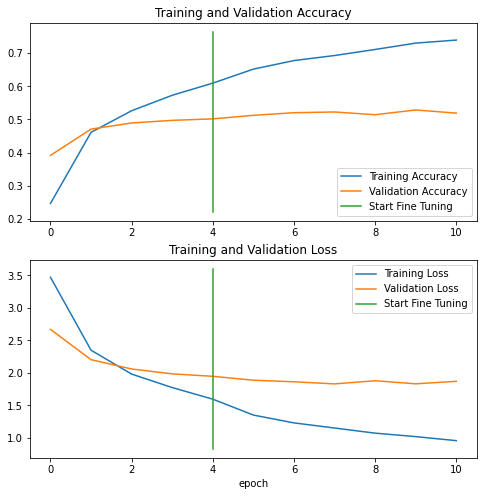

In [21]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs =5 )

## Saving and loading our model
To use our model in an external application, we will ned to save it and export it somewhere

In [22]:
# save our fine-tuning model
model.save("drive/MyDrive/save files/101_food_class_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/save files/101_food_class_10_percent_saved_big_dog_model/assets


In [23]:
#load an evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/save files/101_food_class_10_percent_saved_big_dog_model")

In [24]:
# Evaluate loaded model and compare performance to presaved model
# loaded_model_result = loaded_model.evaluate(test_data)
# loaded_model_result

In [25]:
# the results from our loaded model (above) should be very similar to the result below
#all_classes_10_percent_fine_tune_results

## Evaluate the performance of the big dog model across all different classes

Letsmake some predictions, visualize them and then later find out which prediction were the most wrong

In [26]:
# Downlaod pretrained model (one that was prepared earlier, so all predictions are similar)
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-07-29 19:35:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.48, 172.217.2.112, 172.217.1.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   239MB/s    in 0.2s    

2022-07-29 19:35:43 (239 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [27]:
#unzip data
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [28]:
# load in saved model
model= tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [29]:
# Evalauted loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 58s 71ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## making predictions with our trained model

In [30]:
# make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbose to see how long is left

790/790 [==============================] - 61s 75ms/step


In [31]:
len(test_data)

790

In [32]:
# How many predictions are there 
len(preds_probs)

25250

In [33]:
#whats the shape of our predictions?
preds_probs.shape

(25250, 101)

In [34]:
# lets see what the first 10 predictions look like
preds_probs[:10]

array([[5.9541997e-02, 3.5742044e-06, 4.1377008e-02, ..., 1.4138679e-09,
        8.3530824e-05, 3.0897509e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780820e-04, ..., 5.4287048e-05,
        7.8362204e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533648e-05, 1.4866963e-03, ..., 7.1891270e-07,
        5.4397265e-07, 4.0275925e-05],
       ...,
       [4.7313246e-01, 1.2931228e-07, 1.4805609e-03, ..., 5.9750048e-04,
        6.6969005e-05, 2.3469245e-05],
       [4.4571832e-02, 4.7265476e-07, 1.2258517e-01, ..., 6.3498501e-06,
        7.5318512e-06, 3.6778776e-03],
       [7.2438955e-01, 1.9249771e-09, 5.2310937e-05, ..., 1.2291373e-03,
        1.5792714e-09, 9.6395648e-05]], dtype=float32)

In [35]:
# what does the first prediction probability array look like:
preds_probs[0], len(preds_probs[0])

(array([5.9541997e-02, 3.5742044e-06, 4.1377008e-02, 1.0660534e-09,
        8.1614111e-09, 8.6639478e-09, 8.0927191e-07, 8.5652403e-07,
        1.9859070e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532185e-04, 7.8049184e-10, 7.4230076e-04, 3.8916409e-05,
        6.4740357e-06, 2.4977301e-06, 3.7891128e-05, 2.0678326e-07,
        1.5538435e-05, 8.1507017e-07, 2.6230514e-06, 2.0010684e-07,
        8.3827518e-07, 5.4216030e-06, 3.7390816e-06, 1.3150530e-08,
        2.7761480e-03, 2.8051860e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688880e-04, 7.6406842e-10, 4.0452872e-04, 1.3150632e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062943e-02, 8.2466846e-07,
        8.5365838e-07, 1.7138658e-06, 7.0525025e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681568e-06, 1.8525114e-07,
        3.3619767e-08, 3.1522580e-04, 1.0410922e-05, 8.5448272e-07,
        8.4741855e-01, 1.0555444e-05, 4.4094620e-07, 3.7404177e-05,
        3.5306122e-05, 3.2489035e-05, 6.7314730e

our model outputs a prediction probability aray (with N number of variables, where N is thenumber of classes) for the same sample passed to the predict method

In [36]:
# we get one prediction probability per class (in our case theres 101 prediction probabilities)
print(f"Number of pediction probabilities for sample 0: {len(preds_probs[0])} ")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the higest predicted probability by the model for sample 0: {preds_probs[0].argmax()} ")

Number of pediction probabilities for sample 0: 101 
What prediction probability sample 0 looks like:
 [5.9541997e-02 3.5742044e-06 4.1377008e-02 1.0660534e-09 8.1614111e-09
 8.6639478e-09 8.0927191e-07 8.5652403e-07 1.9859070e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532185e-04 7.8049184e-10 7.4230076e-04
 3.8916409e-05 6.4740357e-06 2.4977301e-06 3.7891128e-05 2.0678326e-07
 1.5538435e-05 8.1507017e-07 2.6230514e-06 2.0010684e-07 8.3827518e-07
 5.4216030e-06 3.7390816e-06 1.3150530e-08 2.7761480e-03 2.8051860e-05
 6.8562017e-10 2.5574853e-05 1.6688880e-04 7.6406842e-10 4.0452872e-04
 1.3150632e-08 1.7957391e-06 1.4448174e-06 2.3062943e-02 8.2466846e-07
 8.5365838e-07 1.7138658e-06 7.0525025e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681568e-06 1.8525114e-07 3.3619767e-08 3.1522580e-04
 1.0410922e-05 8.5448272e-07 8.4741855e-01 1.0555444e-05 4.4094620e-07
 3.7404177e-05 3.5306122e-05 3.2489035e-05 6.7314730e-05 1.2852565e-08
 2.6219704e-10 1.0318108e-05 8.5744112e-05 1.

In [37]:
# get the pred classesof each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [38]:
 # how manypred classes do we have??
 len(pred_classes)

25250

Now we have got a predictions array of all our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [39]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labelslook like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1 occurs"
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [40]:
#how many y_labels are there?
len(y_labels)

25250

## Evaluating our models predictions

One way to check that our model's predictions array is the same order as our test labels array is to find the accuracy score.

In [41]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]